In [1]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA # Principal component analysis
import torch # Neural network training and inference
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numpy.linalg import eig
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import patsy

# Parameters which AI Poincare and PullNN classes are using for inference
PREPROCESS_EIGENVALUE_THRESHOLD = 0.001 # Threshold for linear invariant
PULLNN_HIDDEN_LAYERS = [256,256] # Pull NN hidden layers
PULLNN_LEAKYRELU_SLOPE = 0 # Slope for the Leaky Rectified Linear Unit
PULLNN_OPTIMIZER_TYPE = 'Adam' # Either Adam or SGD
PULLNN_LEARNING_RATE = 0.001 # Learning rate for optimization
PULLNN_BATCH_SIZE = 1024 # Batch size for training
PULLNN_TRAIN_ITER = 500 # Number of training iterations
PULLNN_TRAIN_LOGITER = 200 # Log after every given number of iterations
NEFF_NPOINTS = 100 # Number of starting points for estimating Neff
NEFF_WALK_STEPS = 2000 # Number of random walk steps to estimate Neff
NEFF_FORMULA_A = 2

In [2]:
def henon_heiles(t, y, lmbda):
    x, y, px, py = y
    
    # Equations of motion
    dxdt = px
    dydt = py
    dpxdt = -x - 2 * lmbda * x * y
    dpydt = -y - lmbda * (x**2 - y**2)
    
    return np.array([dxdt, dydt, dpxdt, dpydt])

def runge_kutta_45_henon_heiles(t0, y0, h, T, lmbda):
    t_values = [t0]
    y_values = [y0]

    num_steps = int((T - t0) / h)

    for _ in range(num_steps):
        t = t_values[-1]
        y = y_values[-1]

        k1 = h * henon_heiles(t, y, lmbda)
        k2 = h * henon_heiles(t + 1/4 * h, y + 1/4 * k1, lmbda)
        k3 = h * henon_heiles(t + 3/8 * h, y + 3/32 * k1 + 9/32 * k2, lmbda)
        k4 = h * henon_heiles(t + 12/13 * h, y + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3, lmbda)
        k5 = h * henon_heiles(t + h, y + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4, lmbda)
        k6 = h * henon_heiles(t + 1/2 * h, y - 8/27 * k1 + 2 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5, lmbda)

        y_new = y + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5

        t_values.append(t + h)
        y_values.append(y_new)

    return np.array(t_values), np.array(y_values)

In [3]:
# Initialize the parameters

tmin = 0

in_cons  = np.array([0, 0.82, 0.1232, 0])  # Initial conditions [x, y, px, py]
in_cons1 = np.array([0, 0.82, 0.12320001, 0])  # Initial conditions [x, y, px, py]

dt = 0.01  # Step size
tmax = np.linspace(1,240,35)  # End time

In [4]:
eiglyap = []
for i in range(len(tmax)):
    

    ##################################################################################################################################################

    t_values, variable_values = runge_kutta_45_henon_heiles(tmin, in_cons, dt, tmax[i],1)
    x_values, y_values, px_values, py_values= np.array(variable_values).T
    
    t_values1, variable_values1 = runge_kutta_45_henon_heiles(tmin, in_cons1, dt, tmax[i],1)
    x_values1, y_values1, px_values1, py_values1= np.array(variable_values1).T
    
    ################################################################################################################################################# 
    
    xnew = x_values1 - x_values
    ynew = y_values1 - y_values
    pxnew = px_values1 - px_values
    pydnew = py_values1 - py_values
    
    dat = []
    dat.append(xnew)
    dat.append(ynew)
    dat.append(pxnew)
    dat.append(pydnew)

    data = np.array(dat).T
    
    ##################################################################################################################################################
    
    
    # Train this data by AIPoincare with a certain training length-scale
    from aipoincare1_lib import AIPoincare
    som = AIPoincare(data)
    Larray = np.logspace(0,2.3,10)/100
    som.run([Larray[6]])
    
    ##################################################################################################################################################
    # Prewhitening part of the algorithm
    PREPROCESS_EIGENVALUE_THRESHOLD = 0.001
    
    # Step 1: Normalized trajectory
    mean_trajectory_data = np.mean(data, axis=0)
    std_trajectory_data = np.std(data, axis=0)
    trajectory_data_normalized0 = (data -
                    mean_trajectory_data[np.newaxis,:])\
                            /std_trajectory_data
    
    # Step 2: Principal Component Analysis to extract linear invariants
    pca = PCA() # Get the PCA object
    transformed_data = pca.fit_transform(trajectory_data_normalized0)
    eigs_above_threshold = np.sum(pca.explained_variance_ratio_
                        > PREPROCESS_EIGENVALUE_THRESHOLD)
    data1 = transformed_data[:,:eigs_above_threshold]
    std_data = np.std(transformed_data,axis=0)
    change_of_basis = pca.components_
    inverse = np.linalg.inv(change_of_basis)
    
    
    # Step 3: Scaling again for isotropy
    trajectory_data_normalized = transformed_data/(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
    
    dim0 = data.shape[0]
    dim1 = data.shape[1]
    ##################################################################################################################################################
    
    nnwidths = som.nn_widths # Neural network architecture
    inf = som.nn_state_dict_list # Some information of trained neural network
    from aipoincare1_lib import PullNN
    pullnn = PullNN(nnwidths) # Set up a fresh network
    pullnn.load_state_dict(inf[0])
    
    eigenvalues = []
    for jj in range(NEFF_NPOINTS): # Iterate to choose random points
        
        ##############################################################################################################################################
        # Generate random perturbations to the point
        choice = np.random.choice(len(data))
        perturb = torch.normal(0, Larray[3], size = (NEFF_WALK_STEPS,
            dim1), dtype=torch.float)
        # Create a bunch of points in the neighborhood
        x0 = torch.tensor(trajectory_data_normalized[choice], dtype=torch.float) + perturb
        # Try to walk all the points back to the manifold and convert the
        # torch tensor to numpy matrix data where required.
        # The Pull Network calculates the distance to the closest point in the
        # manifold. So to get back to the manifold we need to add x0. This is
        # different from how the paper is phrased. Not sure why this helps.
        pull_back = pullnn(x0).detach() # Detach from the network
        # Pull back all points to the local tangent plane.
        x0 = x0 + pull_back
        x1 = x0.tolist()
        #Convert data to nonscaled case for checking the invariants
        # 1)scaling, 2)pca, 3)scaling again
        # Have to go back from where we began
        x11 = np.array(x1)*(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
        x12 = np.matmul(inverse,x11.T).T
        x2 = x12*(std_trajectory_data)+mean_trajectory_data[np.newaxis,:]
        
        # Step 3: Find the dimensionality of the local set of points
        pca = PCA() # Declare a Principal Component Analysis object
        pca.fit(x2) # Try to fit to the trajectory data
        svs = pca.singular_values_ # Get the eigenvalues
        eigenvalues.append(svs)
        ##############################################################################################################################################
    
    eigs = np.array(eigenvalues)
    lambdas = np.mean(eigs,axis=0)
    eiglyap.append(lambdas)
    
variations = np.array(eiglyap)

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


In [5]:
lyapunov = []
for i in range(len(tmax)):
    lyapunov.append( np.mean(np.log(variations[i]/variations[0])/tmax[i]) )
    
lyapunovs = np.array(lyapunov)

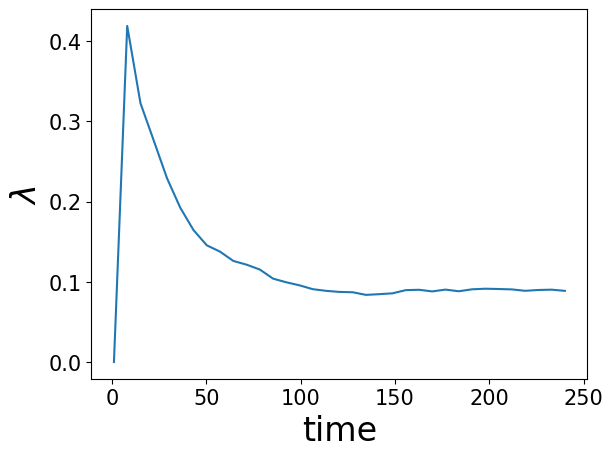

In [6]:
plt.plot(tmax,lyapunovs)
plt.xlabel('time', fontsize=24)
plt.ylabel(r'$\lambda$', fontsize=24)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig('henon_lyap.pdf')
plt.show()

In [7]:
lyapunovs

array([0.        , 0.41906755, 0.32267393, 0.27611199, 0.22920163,
       0.19230389, 0.16440006, 0.14545351, 0.13752856, 0.12595799,
       0.12129191, 0.11520846, 0.10386688, 0.09930127, 0.09547894,
       0.09069969, 0.08864604, 0.08729509, 0.08690203, 0.08361472,
       0.08449007, 0.08554083, 0.08951596, 0.08996943, 0.08794683,
       0.09018885, 0.08814755, 0.09055853, 0.09130086, 0.09093762,
       0.09045551, 0.08870244, 0.08971284, 0.09011371, 0.08863273])